# Supervised Classification on Crypto Time Series
### Experiment 1

Author: Louis Wong

Email: lwong64@gatech.edu

In [1]:
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(20)
tf.random.set_seed(20)
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
import pandas as pd

df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df

,close,high,low,trade_count,open,time,volume,vwap,symbol
0,29676.7900,29682.290,28707.560000,29639,29255.710,2021-01-01 06:00:00+00:00,848.874030,29316.444625,BTC/USD
1,33769.5200,34200.000,29555.990000,60152,29678.340,2021-01-02 06:00:00+00:00,2144.592516,31941.412694,BTC/USD
2,32908.0200,34812.930,32300.610000,58725,33769.520,2021-01-03 06:00:00+00:00,1838.695433,33505.269474,BTC/USD
3,30441.5700,33496.030,27900.000000,69226,32907.360,2021-01-04 06:00:00+00:00,2711.189503,31267.965121,BTC/USD
4,35063.0000,35851.420,29927.550000,61880,30461.840,2021-01-05 06:00:00+00:00,1756.751333,33151.367357,BTC/USD
...,...,...,...,...,...,...,...,...,...
966,26059.7200,26288.942,25772.200000,99,26017.478,2023-08-25 05:00:00+00:00,1.257720,26081.686371,BTC/USD
967,26022.1685,26077.372,25957.655000,60,26042.840,2023-08-26 05:00:00+00:00,0.264765,26028.641030,BTC/USD
968,26010.7650,26170.500,25981.980000,73,26025.635,2023-08-27 05:00:00+00:00,0.486812,26070.921160,BTC/USD
969,26032.6905,26223.800,25873.126873,152,26006.100,2023-08-28 05:00:00+00:00,2.111867,26027.386657,BTC/USD


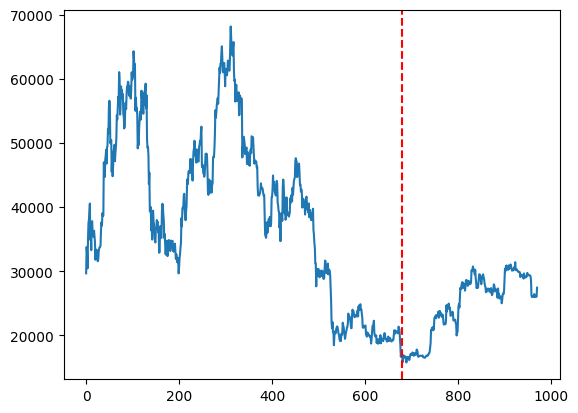

In [4]:
import matplotlib.pyplot as plt
import math

df['close'].plot()
splitat = math.floor(len(df) * 0.7)
plt.axvline(x=splitat, color='r', linestyle='--')

<AxesSubplot: >

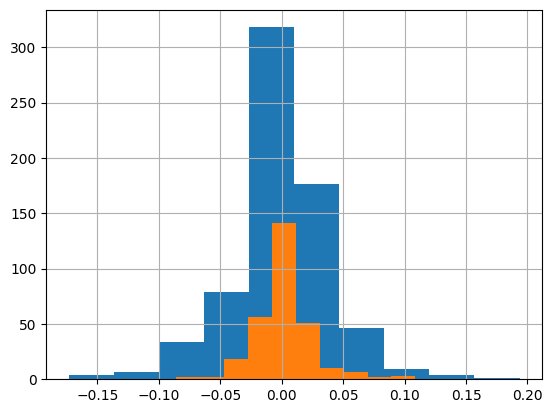

In [5]:
import numpy as np

df['log_return'] = np.log(df['close']).diff()
df['log_return'][:splitat].hist()
df['log_return'][splitat:].hist()

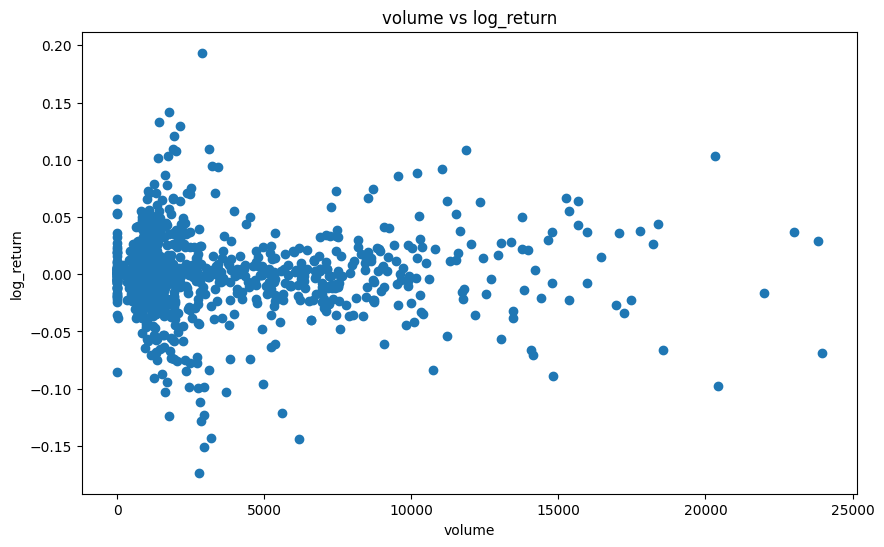

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(df['volume'], df['log_return'])
plt.xlabel('volume')
plt.ylabel('log_return')
plt.title('volume vs log_return')
plt.show()

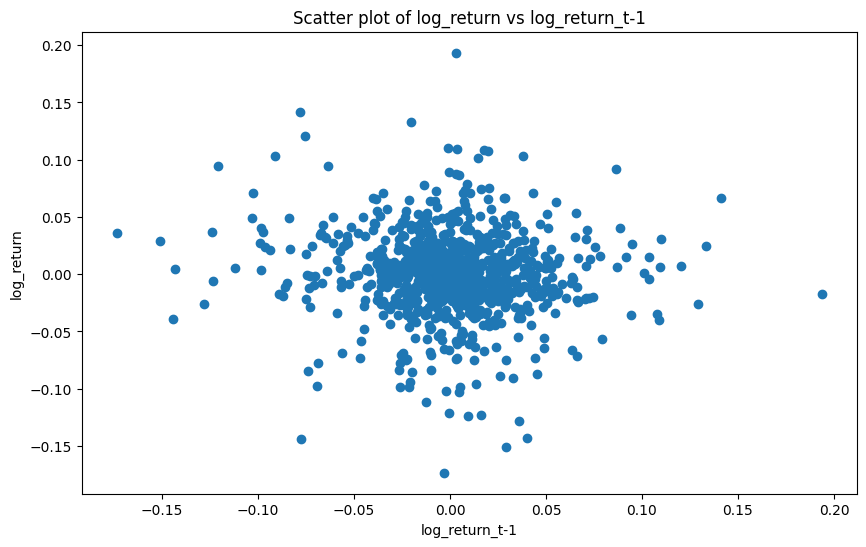

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(x=df['log_return'].shift(1), y=df['log_return'])
plt.title('Scatter plot of log_return vs log_return_t-1')
plt.xlabel('log_return_t-1')
plt.ylabel('log_return')
plt.show()

In [8]:
# Pearson correlation
correlation = df['log_return'].corr(df['log_return'].shift(1))
print('Pearson correlation:', correlation)

Pearson correlation: -0.07369304112832391


In [9]:
df['positive_return'] = (df['log_return'] > 0).astype(int)
pos = len(df[df["positive_return"] == 1])
neg = len(df[df["positive_return"] == 0])
print(f'Positive: {pos}\nNegative: {neg}\nRatio: {(pos/(pos+neg)):.4f}')

Positive: 490
Negative: 481
Ratio: 0.5046


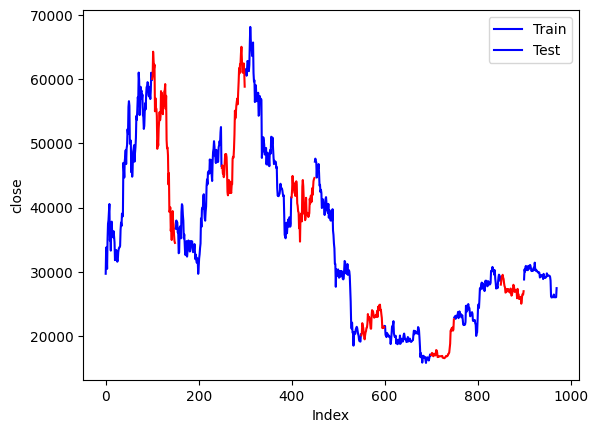

In [10]:
train_length = 100  # Length of 'Train' sections
test_length = 50  # Length of 'Test' sections

df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]

# find the start and end of each section
starts_train = df_train.index[::train_length]
ends_train = np.append(starts_train[1:] - 1, df_train.index[-1])
starts_test = df_test.index[::test_length]
ends_test = np.append(starts_test[1:] - 1, df_test.index[-1])

# plot each section separately
for start, end in zip(starts_train, ends_train):
    plt.plot(df_train.loc[start:end].index, df_train.loc[start:end]['close'], 'b')
for start, end in zip(starts_test, ends_test):
    plt.plot(df_test.loc[start:end].index, df_test.loc[start:end]['close'], 'r')

plt.xlabel('Index')
plt.ylabel('close')
plt.legend(['Train', 'Test'])
plt.show()

<AxesSubplot: >

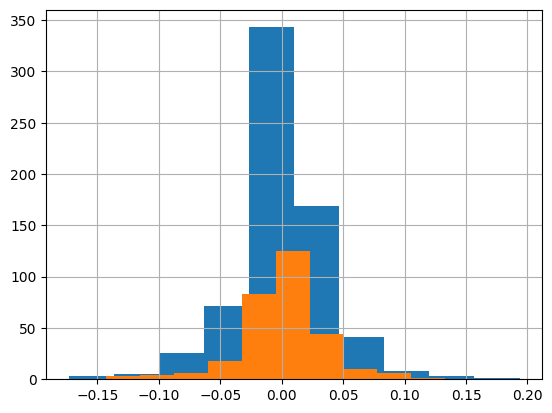

In [11]:
df_train['log_return'].hist()
df_test['log_return'].hist()

In [12]:
len(df_train), len(df_test)

(671, 300)

<AxesSubplot: >

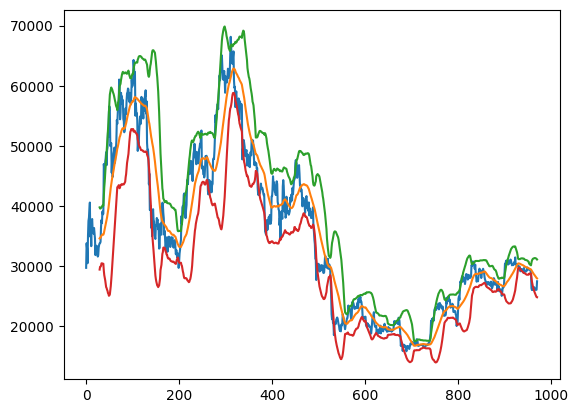

In [13]:
# Add SMA
def SMA(data, period=30, column='close'):
    return data[column].rolling(window=period).mean()

# Add Bollinger Bands
def BollingerBands(data, period=30, column='close'):
    sma = SMA(data, period, column=column)
    rolling_std = data[column].rolling(window=period).std()
    upper_band = sma + (rolling_std * 2)
    lower_band = sma - (rolling_std * 2)
    return upper_band, sma, lower_band

# Add RSI
def RSI(data, period=14, column='close'):
    delta = data[column].diff(1)
    loss = (delta.where(delta < 0, 0)).abs()
    gain = (delta.where(delta > 0, 0))
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_indicators(df):
    df['sma'] = SMA(df)
    df['upper_band'], df['middle_band'], df['lower_band'] = BollingerBands(df)
    df['rsi'] = RSI(df)
    return df

df = add_indicators(df)
df['close'].plot()
df['sma'].plot()
df['upper_band'].plot()
df['lower_band'].plot()

<AxesSubplot: >

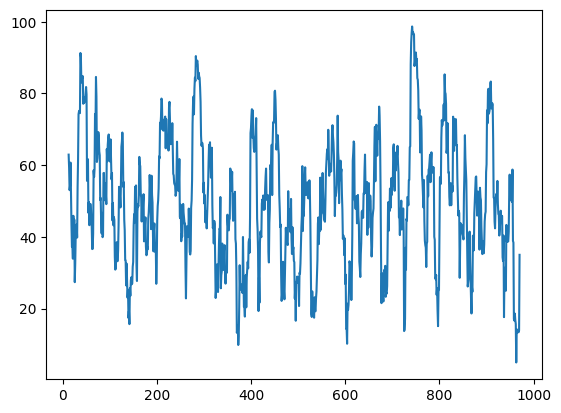

In [14]:
df['rsi'].plot()

In [15]:
def redefine_indicators(df):
    df['sma'] = df['sma'] / df['close']
    df['upper_band'], df['middle_band'], df['lower_band'] = df['upper_band']/ df['close'], df['middle_band']/ df['close'], df['lower_band']/ df['close']
    df['rsi'] = RSI(df) / 50
    return df

df = redefine_indicators(df)
df

,close,high,low,trade_count,open,time,volume,vwap,symbol,log_return,positive_return,train,sma,upper_band,middle_band,lower_band,rsi
0,29676.7900,29682.290,28707.560000,29639,29255.710,2021-01-01 06:00:00+00:00,848.874030,29316.444625,BTC/USD,NaN,0,True,NaN,NaN,NaN,NaN,NaN
1,33769.5200,34200.000,29555.990000,60152,29678.340,2021-01-02 06:00:00+00:00,2144.592516,31941.412694,BTC/USD,0.129193,1,True,NaN,NaN,NaN,NaN,NaN
2,32908.0200,34812.930,32300.610000,58725,33769.520,2021-01-03 06:00:00+00:00,1838.695433,33505.269474,BTC/USD,-0.025842,0,True,NaN,NaN,NaN,NaN,NaN
3,30441.5700,33496.030,27900.000000,69226,32907.360,2021-01-04 06:00:00+00:00,2711.189503,31267.965121,BTC/USD,-0.077907,0,True,NaN,NaN,NaN,NaN,NaN
4,35063.0000,35851.420,29927.550000,61880,30461.840,2021-01-05 06:00:00+00:00,1756.751333,33151.367357,BTC/USD,0.141337,1,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,26059.7200,26288.942,25772.200000,99,26017.478,2023-08-25 05:00:00+00:00,1.257720,26081.686371,BTC/USD,0.001530,1,True,1.086595,1.200654,1.086595,0.972535,0.273952
967,26022.1685,26077.372,25957.655000,60,26042.840,2023-08-26 05:00:00+00:00,0.264765,26028.641030,BTC/USD,-0.001442,0,True,1.084015,1.201770,1.084015,0.966259,0.273363
968,26010.7650,26170.500,25981.980000,73,26025.635,2023-08-27 05:00:00+00:00,0.486812,26070.921160,BTC/USD,-0.000438,0,True,1.080165,1.200595,1.080165,0.959735,0.267880
969,26032.6905,26223.800,25873.126873,152,26006.100,2023-08-28 05:00:00+00:00,2.111867,26027.386657,BTC/USD,0.000843,1,True,1.075040,1.197369,1.075040,0.952711,0.278509


In [16]:
def applylogdiff(df):
    for col in df.columns:
        if col not in ['log_return','time','symbol','train','positive_return']:
            df[col+'_logdiff'] = np.log(df[col]).diff()
            df = df.drop([col], axis=1)
    return df

df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df

,log_return,positive_return,train,close_logdiff,high_logdiff,low_logdiff,trade_count_logdiff,open_logdiff,volume_logdiff,vwap_logdiff,sma_logdiff,upper_band_logdiff,middle_band_logdiff,lower_band_logdiff,rsi_logdiff
0,NaN,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.129193,1,True,0.129193,0.141675,0.029126,0.707784,0.014343,0.926794,0.085755,NaN,NaN,NaN,NaN,NaN
2,-0.025842,0,True,-0.025842,0.017763,0.088800,-0.024009,0.129141,-0.153893,0.047799,NaN,NaN,NaN,NaN,NaN
3,-0.077907,0,True,-0.077907,-0.038562,-0.146459,0.164511,-0.025862,0.388331,-0.069109,NaN,NaN,NaN,NaN,NaN
4,0.141337,1,True,0.141337,0.067956,0.070153,-0.112179,-0.077222,-0.433921,0.058490,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,0.001530,1,True,0.001530,-0.010299,-0.006507,-0.208901,-0.016577,-0.434168,-0.007305,-0.005558,-0.002085,-0.005558,-0.009830,0.026257
967,-0.001442,0,True,-0.001442,-0.008080,0.007170,-0.500775,0.000974,-1.558212,-0.002036,-0.002377,0.000929,-0.002377,-0.006475,-0.002154
968,-0.000438,0,True,-0.000438,0.003565,0.000937,0.196115,-0.000661,0.609033,0.001623,-0.003558,-0.000979,-0.003558,-0.006774,-0.020259
969,0.000843,1,True,0.000843,0.002035,-0.004198,0.733421,-0.000751,1.467450,-0.001671,-0.004756,-0.002690,-0.004756,-0.007346,0.038911


In [17]:
import warnings

def applylag(df, laglength=10):
    warnings.filterwarnings('ignore')
    for col in df.columns:
        for i in range(1, laglength+1):
            df[col+'_t-'+str(i)] = df[col].shift(i)
    return df

df = applylag(df, laglength=10)
df

,log_return,positive_return,train,close_logdiff,high_logdiff,low_logdiff,trade_count_logdiff,open_logdiff,volume_logdiff,vwap_logdiff,...,rsi_logdiff_t-1,rsi_logdiff_t-2,rsi_logdiff_t-3,rsi_logdiff_t-4,rsi_logdiff_t-5,rsi_logdiff_t-6,rsi_logdiff_t-7,rsi_logdiff_t-8,rsi_logdiff_t-9,rsi_logdiff_t-10
0,NaN,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.129193,1,True,0.129193,0.141675,0.029126,0.707784,0.014343,0.926794,0.085755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.025842,0,True,-0.025842,0.017763,0.088800,-0.024009,0.129141,-0.153893,0.047799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.077907,0,True,-0.077907,-0.038562,-0.146459,0.164511,-0.025862,0.388331,-0.069109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.141337,1,True,0.141337,0.067956,0.070153,-0.112179,-0.077222,-0.433921,0.058490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,0.001530,1,True,0.001530,-0.010299,-0.006507,-0.208901,-0.016577,-0.434168,-0.007305,...,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604,-0.810810,-0.012114,-0.413159
967,-0.001442,0,True,-0.001442,-0.008080,0.007170,-0.500775,0.000974,-1.558212,-0.002036,...,0.026257,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604,-0.810810,-0.012114
968,-0.000438,0,True,-0.000438,0.003565,0.000937,0.196115,-0.000661,0.609033,0.001623,...,-0.002154,0.026257,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604,-0.810810
969,0.000843,1,True,0.000843,0.002035,-0.004198,0.733421,-0.000751,1.467450,-0.001671,...,-0.020259,-0.002154,0.026257,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604


In [18]:
def remove_leaks(df, laglength=10, verbose=True):
    df['leaks'] = (df['train']) & (df['train'].shift(laglength) == False)
    leaks = len(df[df['leaks']])
    df = df[df['leaks']==False]
    df = df.drop('leaks',axis=1)
    if verbose:
        print(f'{leaks} leaks removed.')
    return df

df = remove_leaks(df, laglength=10)
df

60 leaks removed.


,log_return,positive_return,train,close_logdiff,high_logdiff,low_logdiff,trade_count_logdiff,open_logdiff,volume_logdiff,vwap_logdiff,...,rsi_logdiff_t-1,rsi_logdiff_t-2,rsi_logdiff_t-3,rsi_logdiff_t-4,rsi_logdiff_t-5,rsi_logdiff_t-6,rsi_logdiff_t-7,rsi_logdiff_t-8,rsi_logdiff_t-9,rsi_logdiff_t-10
0,NaN,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.129193,1,True,0.129193,0.141675,0.029126,0.707784,0.014343,0.926794,0.085755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.025842,0,True,-0.025842,0.017763,0.088800,-0.024009,0.129141,-0.153893,0.047799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.077907,0,True,-0.077907,-0.038562,-0.146459,0.164511,-0.025862,0.388331,-0.069109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.141337,1,True,0.141337,0.067956,0.070153,-0.112179,-0.077222,-0.433921,0.058490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,0.001530,1,True,0.001530,-0.010299,-0.006507,-0.208901,-0.016577,-0.434168,-0.007305,...,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604,-0.810810,-0.012114,-0.413159
967,-0.001442,0,True,-0.001442,-0.008080,0.007170,-0.500775,0.000974,-1.558212,-0.002036,...,0.026257,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604,-0.810810,-0.012114
968,-0.000438,0,True,-0.000438,0.003565,0.000937,0.196115,-0.000661,0.609033,0.001623,...,-0.002154,0.026257,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604,-0.810810
969,0.000843,1,True,0.000843,0.002035,-0.004198,0.733421,-0.000751,1.467450,-0.001671,...,-0.020259,-0.002154,0.026257,-0.065237,1.052893,-1.149343,-0.067295,-0.103807,0.112563,-0.026604


In [19]:
# get the next day return
df['log_return'] = df['log_return'].shift(-1)

# convert log_return to binary
df['positive_return'] = (df['log_return'] > 0).astype(int)

# drop the null value created by the lag function
df.dropna(inplace=True)

# split the dataframe
X_train = df[df['train'] == True].drop(['log_return','train','positive_return'], axis=1)
X_test = df[df['train'] == False].drop(['log_return','train','positive_return'], axis=1)
y_train = df[df['train'] == True]['positive_return']
y_test = df[df['train'] == False]['positive_return']
print(f'X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_train:{len(y_test)}')

X_train:570
X_test:300
y_train:570
y_train:300


decision_tree finished in 0 minutes 0.28 seconds


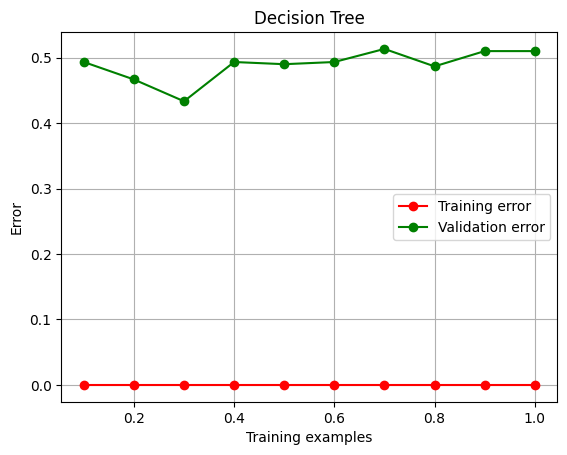

neural_network finished in 0 minutes 20.23 seconds


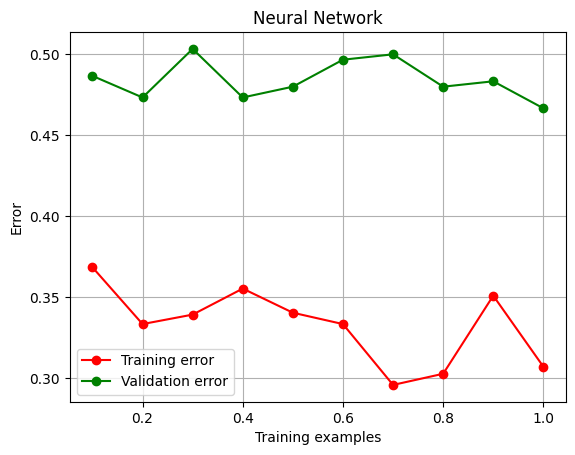

boosting finished in 0 minutes 8.24 seconds


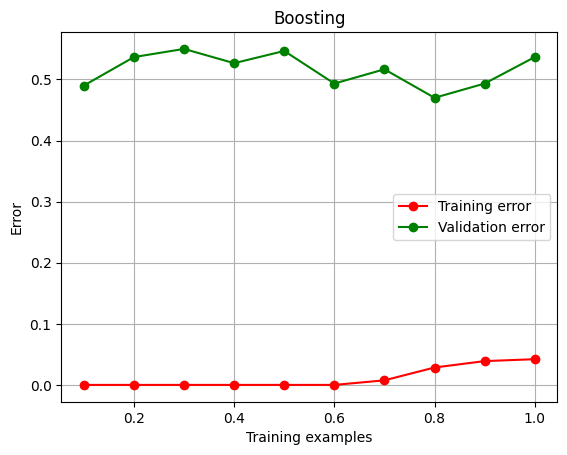

svm finished in 0 minutes 0.42 seconds


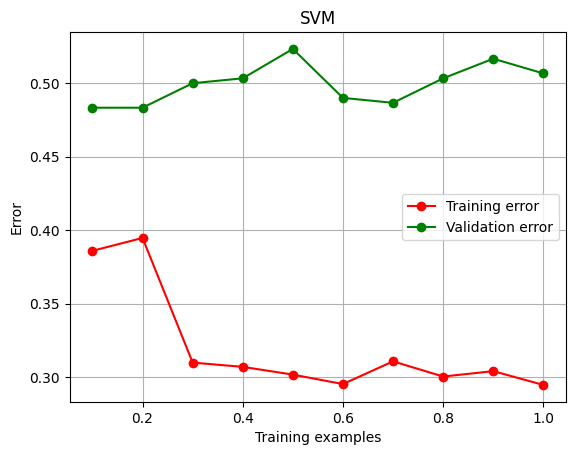

k_nearest_neighbors finished in 0 minutes 0.55 seconds


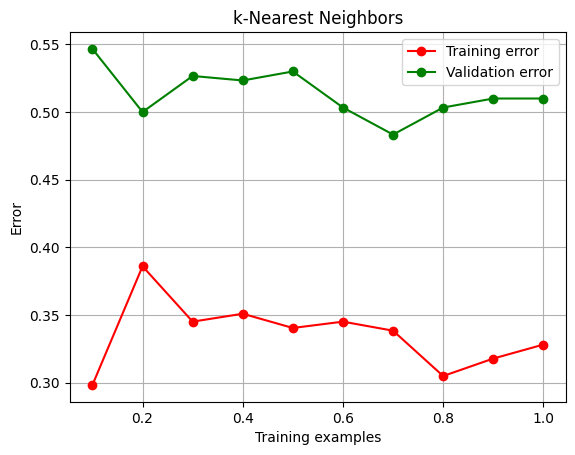

In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
warnings.filterwarnings('ignore')

import time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        minutes, seconds = divmod(end - start, 60)
        print(f"{func.__name__} finished in {int(minutes)} minutes {int(seconds)} seconds")
        return result
    return wrapper

def decision_tree(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier(random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def neural_network2(X_train, y_train, X_test, y_test, hidden_layer_sizes=(100,)):
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)
    clf.fit(X_train, y_train, shuffle=False)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def df_to_tensor(df, laglength=10):
    base_features = [col for col in df.columns.tolist() if '-' not in col]
    
    time_lags = range(1, laglength+1)

    ordered_columns = []
    ordered_columns += base_features
    for t in time_lags:
        ordered_columns += [f'{feature}_t-{t}' for feature in base_features]
        
    df_ordered = df[ordered_columns]
    return df_ordered.values.reshape(-1, 1, df_ordered.shape[1])

# LTSM implmentation
def neural_network(X_train, y_train, X_test, y_test, hidden_units=100, epochs=10, batch_size=32, mlp_depth=1):
    initializer = tf.keras.initializers.GlorotUniform(seed=20)
    laglength = int(X_train.columns.tolist()[-1].split('-')[1])
    X_train = df_to_tensor(X_train, laglength=laglength)
    X_test = df_to_tensor(X_test, laglength=laglength)
    
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy
    return train_error, test_error


def boosting(X_train, y_train, X_test, y_test, n_estimators=100):
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def svm(X_train, y_train, X_test, y_test, kernel='rbf'):
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def k_nearest_neighbors(X_train, y_train, X_test, y_test, n_neighbors=5):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def plot_learning_curve(train_sizes, train_errors, test_errors, title):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    plt.grid()
    plt.plot(train_sizes, train_errors, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, test_errors, 'o-', color="g", label="Validation error")
    plt.legend(loc="best")
    plt.show()

def train_and_plot(X_train, y_train, X_test, y_test):
    model_functions = [decision_tree, neural_network, boosting, svm, k_nearest_neighbors]
    model_names = ['Decision Tree', 'Neural Network', 'Boosting', 'SVM', 'k-Nearest Neighbors']
    train_sizes = np.linspace(.1, 1.0, 10)

    for model_func, name in zip(model_functions, model_names):
        start = time.time()
        train_errors = []
        test_errors = []
        for train_size in train_sizes:
            num_train_samples = int(train_size * X_train.shape[0])
            X_train_subset = X_train[:num_train_samples]
            y_train_subset = y_train[:num_train_samples]
            train_error, test_error = model_func(X_train_subset, y_train_subset, X_test, y_test)
            train_errors.append(train_error)
            test_errors.append(test_error)
        end = time.time()
        minutes, seconds = divmod(end - start, 60)
        print(f"{model_func.__name__} finished in {int(minutes)} minutes {round(seconds,2)} seconds")
        plot_learning_curve(np.linspace(.1, 1.0, 10), train_errors, test_errors, name)
        
train_and_plot(X_train, y_train, X_test, y_test)

In [21]:
def get_rank_df(X_train, y_train, X_test, y_test):
    model_functions = [decision_tree, neural_network, boosting, svm, k_nearest_neighbors]
    model_names = ['Decision Tree', 'Neural Network', 'Boosting', 'SVM', 'k-Nearest Neighbors']
    results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])
    for model_func, name in zip(model_functions, model_names):
        train_error, test_error = model_func(X_train, y_train, X_test, y_test)
        train_accuracy = 1 - train_error
        test_accuracy = 1 - test_error
        results = results.append({'Model': name, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy}, ignore_index=True)

    results.sort_values('Test Accuracy', inplace=True, ascending=False)
    results.reset_index(drop=True, inplace=True)
    return results

results = get_rank_df(X_train, y_train, X_test, y_test)
results

,Model,Train Accuracy,Test Accuracy
0,Neural Network,0.692982,0.533333
1,SVM,0.705263,0.493333
2,Decision Tree,1.000000,0.490000
3,k-Nearest Neighbors,0.671930,0.490000
4,Boosting,0.957895,0.463333


In [22]:
# repeat everything without adding indicator
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=10)
df = remove_leaks(df, laglength=10)
df.dropna(inplace=True)

# split the dataframe
X_train = df[df['train'] == True].drop(['log_return','train','positive_return'], axis=1)
X_test = df[df['train'] == False].drop(['log_return','train','positive_return'], axis=1)
y_train = df[df['train'] == True]['positive_return']
y_test = df[df['train'] == False]['positive_return']

results_without_indicators = get_rank_df(X_train, y_train, X_test, y_test)
results_without_indicators

60 leaks removed.


,Model,Train Accuracy,Test Accuracy
0,Neural Network,0.639399,0.516667
1,Decision Tree,1.000000,0.496667
2,Boosting,0.914858,0.493333
3,SVM,0.689482,0.490000
4,k-Nearest Neighbors,0.682805,0.490000


In [23]:
results_without_indicators = results_without_indicators.add_suffix('_without_indicators')
merged_df = pd.merge(results, results_without_indicators, left_on='Model', right_on='Model_without_indicators')
merged_df = merged_df.drop(['Model_without_indicators', 'Train Accuracy','Train Accuracy_without_indicators'], axis=1)
merged_df['Indicators Gain'] = merged_df['Test Accuracy'] - merged_df['Test Accuracy_without_indicators']
merged_df

,Model,Test Accuracy,Test Accuracy_without_indicators,Indicators Gain
0,Neural Network,0.533333,0.516667,0.016667
1,SVM,0.493333,0.490000,0.003333
2,Decision Tree,0.490000,0.496667,-0.006667
3,k-Nearest Neighbors,0.490000,0.490000,0.000000
4,Boosting,0.463333,0.493333,-0.030000


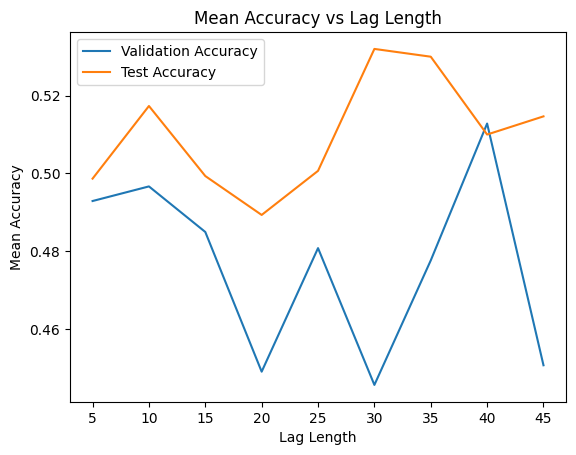

In [24]:
from sklearn.model_selection import train_test_split

def get_models_mean(laglength=20):
    df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
    df['log_return'] = np.log(df['close']).diff()
    df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
    df['log_return'] = df['log_return'].shift(-1)
    df['positive_return'] = (df['log_return'] > 0).astype(int)
    df = applylogdiff(df)
    df = df.drop(['time','symbol'], axis=1)
    df = applylag(df, laglength=laglength)
    df = remove_leaks(df, laglength=laglength, verbose=False)
    df.dropna(inplace=True)

    # split the dataframe
    df_train = df[df['train'] == True]
    df_test = df[df['train'] == False]
    
    # get a vaildation set from train set
    df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)
    
    X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
    y_train = df_trainset['positive_return']
    
    X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
    y_val = df_valset['positive_return']
    
    X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
    y_test = df_test['positive_return']

    results_val = get_rank_df(X_train, y_train, X_val, y_val)
    results = get_rank_df(X_train, y_train, X_test, y_test)
    return results_val['Test Accuracy'].mean(), results['Test Accuracy'].mean()


scores = []
for i in np.arange(5, 50, 5):
    scores.append(get_models_mean(laglength=i))

# unpack scores
val_scores, test_scores = zip(*scores)

# plot
plt.plot(np.arange(5, 50, 5), val_scores, label='Validation Accuracy')
plt.plot(np.arange(5, 50, 5), test_scores, label='Test Accuracy')
plt.xlabel('Lag Length')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Lag Length')
plt.legend()
plt.show()

In [25]:
# repeat everything without adding indicator
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40)
df.dropna(inplace=True)

# split the dataframe
X_train = df[df['train'] == True].drop(['log_return','train','positive_return'], axis=1)
X_test = df[df['train'] == False].drop(['log_return','train','positive_return'], axis=1)
y_train = df[df['train'] == True]['positive_return']
y_test = df[df['train'] == False]['positive_return']

results_without_indicators2 = get_rank_df(X_train, y_train, X_test, y_test)
results_without_indicators2

240 leaks removed.


,Model,Train Accuracy,Test Accuracy
0,Neural Network,0.894602,0.546667
1,k-Nearest Neighbors,0.673522,0.546667
2,Boosting,1.000000,0.510000
3,SVM,0.735219,0.496667
4,Decision Tree,1.000000,0.466667


In [26]:
results_without_indicators2 = results_without_indicators2.add_suffix('_without_indicators2')
merged_df = pd.merge(results_without_indicators2, results_without_indicators, left_on='Model_without_indicators2', right_on='Model_without_indicators')

merged_df = merged_df[['Model_without_indicators','Test Accuracy_without_indicators2','Test Accuracy_without_indicators']]
merged_df['Optimal Lag Gain'] = merged_df['Test Accuracy_without_indicators2'] - merged_df['Test Accuracy_without_indicators']
merged_df

,Model_without_indicators,Test Accuracy_without_indicators2,Test Accuracy_without_indicators,Optimal Lag Gain
0,Neural Network,0.546667,0.516667,0.030000
1,k-Nearest Neighbors,0.546667,0.490000,0.056667
2,Boosting,0.510000,0.493333,0.016667
3,SVM,0.496667,0.490000,0.006667
4,Decision Tree,0.466667,0.496667,-0.030000


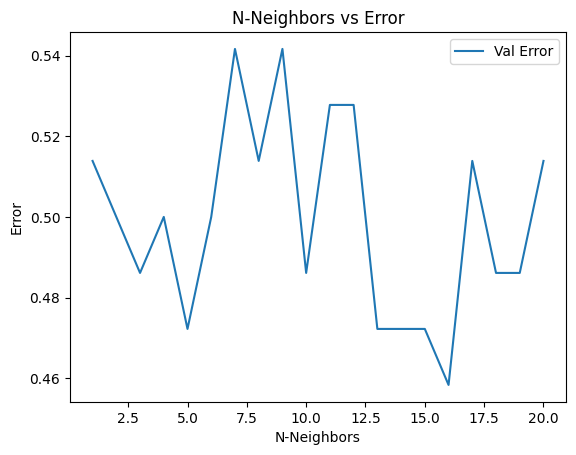

In [28]:
# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']

results = pd.DataFrame(columns=['N-Neighbors', 'Train Error', 'Val Error'])
for i in range(1,21):
    train_error, test_error = k_nearest_neighbors(X_train, y_train, X_val, y_val, n_neighbors=i)
    results = results.append({'N-Neighbors': i, 'Train Error': train_error, 'Val Error': test_error}, ignore_index=True)

# plot
#plt.plot(results['N-Neighbors'], results['Train Error'], label='Train Error')
plt.plot(results['N-Neighbors'], results['Val Error'], label='Val Error')
plt.xlabel('N-Neighbors')
plt.ylabel('Error')
plt.title('N-Neighbors vs Error')
plt.legend()
plt.show()

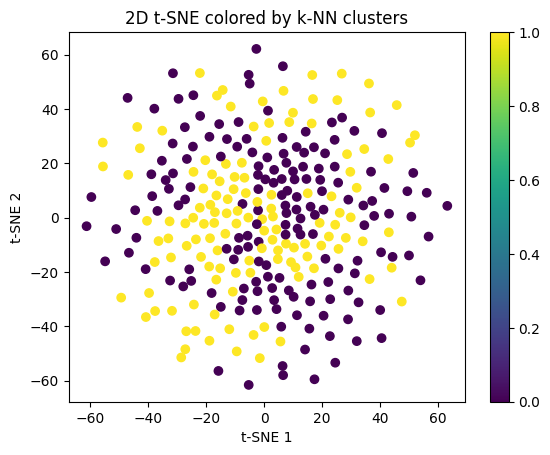

In [29]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# standardize for t-SNE
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)

# 2D t-SNE
tsne = TSNE(n_components=2)
X_train_reduced = tsne.fit_transform(X_train_standardized)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_train_reduced)

# plot
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_pred)
plt.colorbar()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('2D t-SNE colored by k-NN clusters')
plt.show()

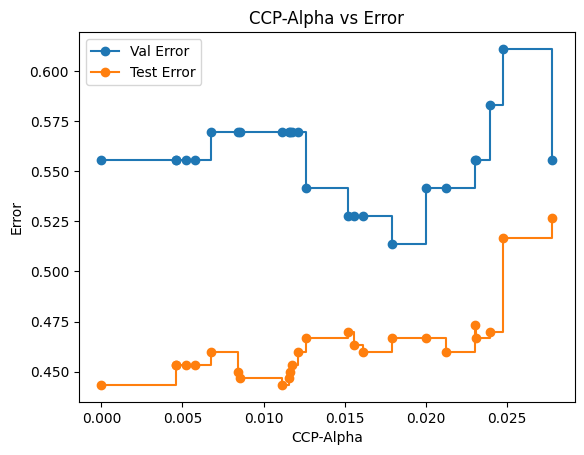

In [30]:
# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']
    
results = pd.DataFrame(columns=['CCP-Alpha', 'Train Error', 'Val Error', 'Test Error'])
path = DecisionTreeClassifier(random_state=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha,random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    val_error = 1 - accuracy_score(y_val, y_pred_val)
    results = results.append({'CCP-Alpha': ccp_alpha, 'Train Error': train_error, 'Val Error': val_error, 'Test Error': test_error}, ignore_index=True)

# plot
#plt.plot(results['CCP-Alpha'], results['Train Error'], label='Train Error', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Val Error'], label='Val Error', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Test Error'], label='Test Error', marker='o', drawstyle="steps-post")
plt.xlabel('CCP-Alpha')
plt.ylabel('Error')
plt.title('CCP-Alpha vs Error')
plt.legend()
plt.show()

In [31]:
results.iloc[results['Val Error'].idxmin()]

CCP-Alpha      0.017919
Train Error    0.156250
Val Error      0.513889
Test Error     0.466667
Name: 17, dtype: float64

In [32]:
results.iloc[results['Test Error'].idxmin()]

CCP-Alpha      0.000000
Train Error    0.000000
Val Error      0.555556
Test Error     0.443333
Name: 0, dtype: float64

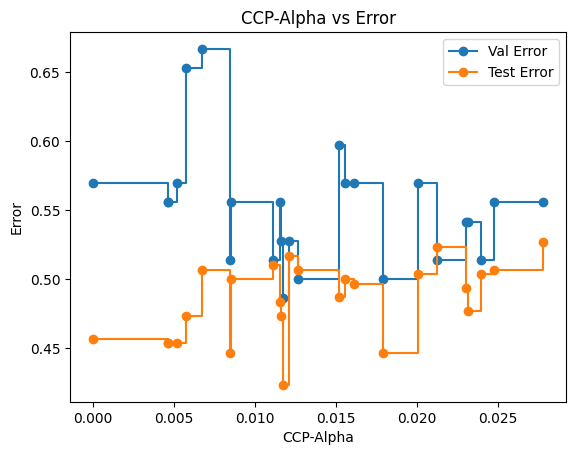

In [33]:
# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']
    
results = pd.DataFrame(columns=['CCP-Alpha', 'Train Error', 'Val Error', 'Test Error'])
path = DecisionTreeClassifier(random_state=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
for ccp_alpha in ccp_alphas:
    base_estimator = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    val_error = 1 - accuracy_score(y_val, y_pred_val)
    results = results.append({'CCP-Alpha': ccp_alpha, 'Train Error': train_error, 'Val Error': val_error, 'Test Error': test_error}, ignore_index=True)

# plot
#plt.plot(results['CCP-Alpha'], results['Train Error'], label='Train Error', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Val Error'], label='Val Error', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Test Error'], label='Test Error', marker='o', drawstyle="steps-post")
plt.xlabel('CCP-Alpha')
plt.ylabel('Error')
plt.title('CCP-Alpha vs Error')
plt.legend()
plt.show()

In [34]:
results.iloc[results['Val Error'].idxmin()]

CCP-Alpha      0.011752
Train Error    0.000000
Val Error      0.486111
Test Error     0.423333
Name: 11, dtype: float64

In [35]:
results.iloc[results['Test Error'].idxmin()]

CCP-Alpha      0.011752
Train Error    0.000000
Val Error      0.486111
Test Error     0.423333
Name: 11, dtype: float64

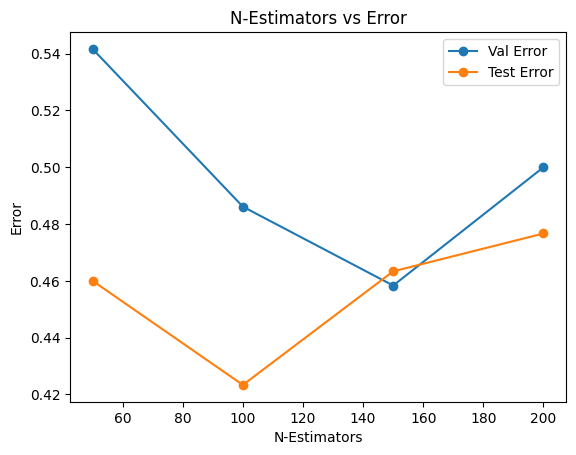

In [36]:
# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']
    
results = pd.DataFrame(columns=['N-Estimators', 'Train Error', 'Val Error', 'Test Error'])

n_estimators = [50, 100, 150, 200]  # specify a list of n_estimators to try

for n in n_estimators:
    base_estimator = DecisionTreeClassifier(ccp_alpha=0.011752, random_state=20)  # adjust ccp_alpha if needed
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n, random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    val_error = 1 - accuracy_score(y_val, y_pred_val)
    results = results.append({'N-Estimators': n, 'Train Error': train_error, 'Val Error': val_error, 'Test Error': test_error}, ignore_index=True)

# plot
#plt.plot(results['N-Estimators'], results['Train Error'], label='Train Error', marker='o')
plt.plot(results['N-Estimators'], results['Val Error'], label='Val Error', marker='o')
plt.plot(results['N-Estimators'], results['Test Error'], label='Test Error', marker='o')
plt.xlabel('N-Estimators')
plt.ylabel('Error')
plt.title('N-Estimators vs Error')
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


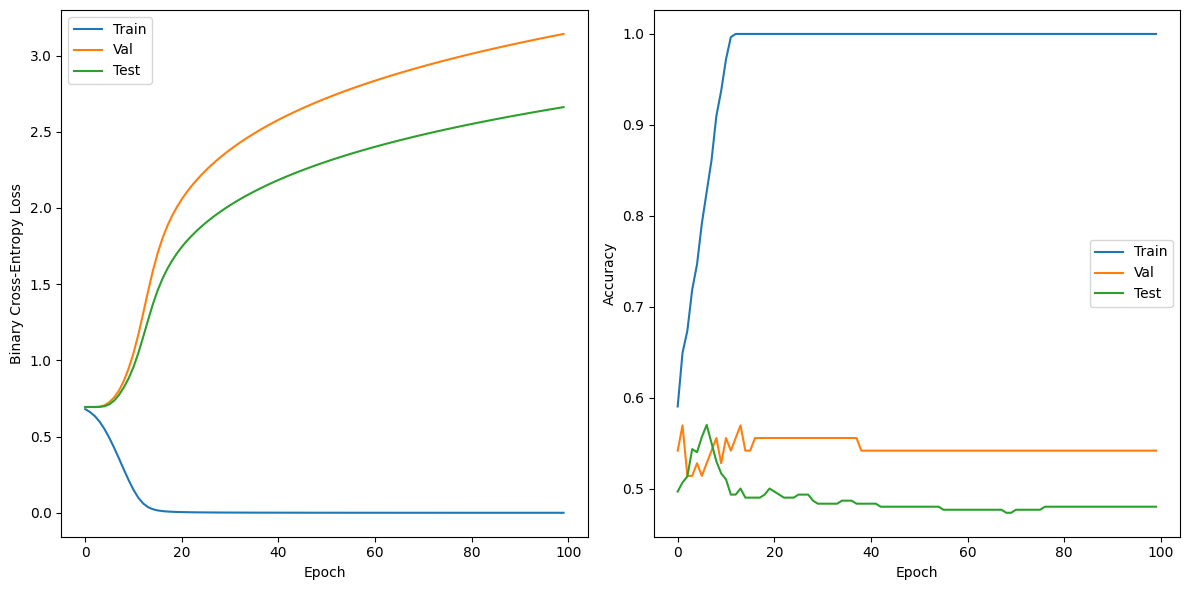

In [37]:
from tqdm import tqdm

# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 100
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)

initializer = tf.keras.initializers.GlorotUniform(seed=20)
model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
for _ in range(mlp_depth):
    model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for epoch in tqdm(range(epochs)):
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), shuffle=False)
    
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

# plot losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()

# plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Val')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
np.argmax(val_accuracies)+1

2

In [39]:
from tqdm import tqdm

# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 2
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)



train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for hidden in tqdm([50,100,200,300,400,500,600]):
    model = Sequential()
    model.add(LSTM(hidden, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
results = pd.DataFrame({
    'Hidden Units':[50,100,200,300,400,500,600],
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  2.19s/it]


,Hidden Units,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
0,50,0.672149,0.693706,0.696853,0.600694,0.513889,0.473333
1,100,0.660779,0.694070,0.694579,0.649306,0.569444,0.506667
2,200,0.634052,0.687975,0.692715,0.711806,0.527778,0.543333
3,300,0.621037,0.691421,0.694569,0.718750,0.513889,0.520000
4,400,0.615686,0.684860,0.694737,0.736111,0.486111,0.523333
5,500,0.606102,0.686741,0.693894,0.729167,0.513889,0.520000
6,600,0.597468,0.688731,0.695619,0.732639,0.500000,0.536667


In [40]:
from tqdm import tqdm

# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 2
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)


train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for batch_size in tqdm([16,32,64,128]):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
results = pd.DataFrame({
    'Batch Size':[16,32,64,128],
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it]


,Batch Size,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
0,16,0.641647,0.692145,0.693839,0.673611,0.555556,0.510000
1,32,0.660779,0.694070,0.694579,0.649306,0.569444,0.506667
2,64,0.670607,0.694009,0.692983,0.642361,0.555556,0.526667
3,128,0.677090,0.693570,0.691853,0.666667,0.513889,0.553333


In [41]:
from tqdm import tqdm

# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 2
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)


train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for depth in tqdm([1,2,3,4,5,6,7,8,9]):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
results = pd.DataFrame({
    'MLP-Depth':[1,2,3,4,5,6,7,8,9],
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.56s/it]


,MLP-Depth,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
0,1,0.660779,0.694070,0.694579,0.649306,0.569444,0.506667
1,2,0.637378,0.699588,0.698147,0.659722,0.486111,0.500000
2,3,0.627661,0.706623,0.702546,0.649306,0.527778,0.496667
3,4,0.620979,0.722105,0.712287,0.659722,0.500000,0.490000
4,5,0.630673,0.741623,0.721663,0.538194,0.444444,0.480000
5,6,0.632679,0.753344,0.729279,0.531250,0.444444,0.473333
6,7,0.632759,0.776001,0.745445,0.531250,0.444444,0.473333
7,8,0.642811,0.778463,0.745292,0.531250,0.444444,0.473333
8,9,0.653449,0.785507,0.753638,0.531250,0.444444,0.473333


In [42]:
from tqdm import tqdm
from keras.optimizers import Adam

# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 2
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)


train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for lr in tqdm([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]):
    optimizer = Adam(learning_rate=lr)
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
results = pd.DataFrame({
    'Learning Rate':['1e-1','1e-2','1e-3','1e-4','1e-5','1e-6'],
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.85s/it]


,Learning Rate,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
0,1e-1,1.189503,1.574071,1.589563,0.590278,0.472222,0.483333
1,1e-2,0.516855,0.733978,0.710442,0.756944,0.486111,0.553333
2,1e-3,0.660779,0.694070,0.694579,0.649306,0.569444,0.506667
3,1e-4,0.693819,0.692421,0.692217,0.503472,0.472222,0.500000
4,1e-5,0.697803,0.692300,0.692024,0.434028,0.500000,0.520000
5,1e-6,0.698216,0.692288,0.692007,0.427083,0.486111,0.516667


In [43]:
# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    val_error = 1 - accuracy_score(y_val, y_pred_val)

    train_losses.append(train_error)
    val_losses.append(val_error)
    test_losses.append(test_error)
    train_accuracies.append(1 - train_error)
    val_accuracies.append(1 - val_error)
    test_accuracies.append(1 - test_error)

results = pd.DataFrame({
    'Kernel': kernels,
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    })

results

,Kernel,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
0,linear,0.121528,0.486111,0.503333,0.878472,0.513889,0.496667
1,poly,0.145833,0.527778,0.510000,0.854167,0.472222,0.490000
2,rbf,0.211806,0.555556,0.493333,0.788194,0.444444,0.506667
3,sigmoid,0.468750,0.527778,0.503333,0.531250,0.472222,0.496667


In [44]:
# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]
    
# get a vaildation set from train set
df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

X_train = df_trainset.drop(['log_return','train','positive_return'], axis=1)
y_train = df_trainset['positive_return']

X_val = df_valset.drop(['log_return','train','positive_return'], axis=1)
y_val = df_valset['positive_return']

X_test = df_test.drop(['log_return','train','positive_return'], axis=1)
y_test = df_test['positive_return']


train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

C = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]


for c in tqdm(C):
    clf = SVC(C=c, kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    val_error = 1 - accuracy_score(y_val, y_pred_val)

    train_losses.append(train_error)
    val_losses.append(val_error)
    test_losses.append(test_error)
    train_accuracies.append(1 - train_error)
    val_accuracies.append(1 - val_error)
    test_accuracies.append(1 - test_error)
    
results = pd.DataFrame({
    'C': C,
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    })

results


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.37it/s]


,C,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
0,0.01,0.468750,0.555556,0.526667,0.531250,0.444444,0.473333
1,0.10,0.468750,0.555556,0.526667,0.531250,0.444444,0.473333
2,1.00,0.211806,0.555556,0.493333,0.788194,0.444444,0.506667
3,10.00,0.003472,0.472222,0.516667,0.996528,0.527778,0.483333
4,100.00,0.000000,0.500000,0.496667,1.000000,0.500000,0.503333
5,1000.00,0.000000,0.500000,0.496667,1.000000,0.500000,0.503333
6,10000.00,0.000000,0.500000,0.496667,1.000000,0.500000,0.503333
7,100000.00,0.000000,0.500000,0.496667,1.000000,0.500000,0.503333


In [51]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
warnings.filterwarnings('ignore')

import time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def decision_tree(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier(random_state=20, ccp_alpha=0.017919)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def df_to_tensor(df, laglength=10):
    base_features = [col for col in df.columns.tolist() if '-' not in col]
    time_lags = range(1, laglength+1)
    ordered_columns = []
    ordered_columns += base_features
    for t in time_lags:
        ordered_columns += [f'{feature}_t-{t}' for feature in base_features]
        
    df_ordered = df[ordered_columns]
    return df_ordered.values.reshape(-1, 1, df_ordered.shape[1])

# LTSM implmentation
def neural_network(X_train, y_train, X_test, y_test):
    # hyperparameters
    hidden_units = 100
    mlp_depth = 1
    epochs = 2
    batch_size = 32
    lr = 1e-3
    
    laglength = int(X_train.columns.tolist()[-1].split('-')[1])
    X_train = df_to_tensor(X_train, laglength=laglength)
    X_test = df_to_tensor(X_test, laglength=laglength)
    
    optimizer = Adam(learning_rate=lr)
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy
    return train_error, test_error


def boosting(X_train, y_train, X_test, y_test):
    base_estimator = DecisionTreeClassifier(ccp_alpha=0.011752, random_state=20)
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def svm(X_train, y_train, X_test, y_test):
    # best parameters base on validation
    kernel = 'linear'
    C = 10
    clf = SVC(C=C, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

def k_nearest_neighbors(X_train, y_train, X_test, y_test):
    # best n_neighbors best on the elbow technique
    n_neighbors = 5
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    return train_error, test_error

In [52]:
# repeat everything
df = pd.read_csv('BTCUSD_3yrs_Daily.csv')
df['log_return'] = np.log(df['close']).diff()
df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
df['log_return'] = df['log_return'].shift(-1)
df['positive_return'] = (df['log_return'] > 0).astype(int)
df = add_indicators(df)
df = redefine_indicators(df)
df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df = applylag(df, laglength=40)
df = remove_leaks(df, laglength=40,verbose=False)
df.dropna(inplace=True)

# split the dataframe
X_train = df[df['train'] == True].drop(['log_return','train','positive_return'], axis=1)
X_test = df[df['train'] == False].drop(['log_return','train','positive_return'], axis=1)
y_train = df[df['train'] == True]['positive_return']
y_test = df[df['train'] == False]['positive_return']

results = get_rank_df(X_train, y_train, X_test, y_test)
results

,Model,Train Accuracy,Test Accuracy
0,Neural Network,0.686111,0.546667
1,Boosting,1.000000,0.530000
2,k-Nearest Neighbors,0.680556,0.523333
3,SVM,0.936111,0.470000
4,Decision Tree,0.744444,0.463333


In [47]:
merged_df = pd.merge(results, results_without_indicators, left_on='Model', right_on='Model_without_indicators')
merged_df = merged_df.drop(['Model_without_indicators', 'Train Accuracy','Train Accuracy_without_indicators'], axis=1)
merged_df['Hyperparameters Optimization Gain'] = merged_df['Test Accuracy'] - merged_df['Test Accuracy_without_indicators']
merged_df

,Model,Test Accuracy,Test Accuracy_without_indicators,Hyperparameters Optimization Gain
0,Neural Network,0.546667,0.516667,0.030000
1,k-Nearest Neighbors,0.523333,0.490000,0.033333
2,Boosting,0.490000,0.493333,-0.003333
3,SVM,0.470000,0.490000,-0.020000
4,Decision Tree,0.463333,0.496667,-0.033333
